# Analysis of MS Fredrika

In [1]:
from py_fish.operation import plot_speed_profile, speed_profile_from_data

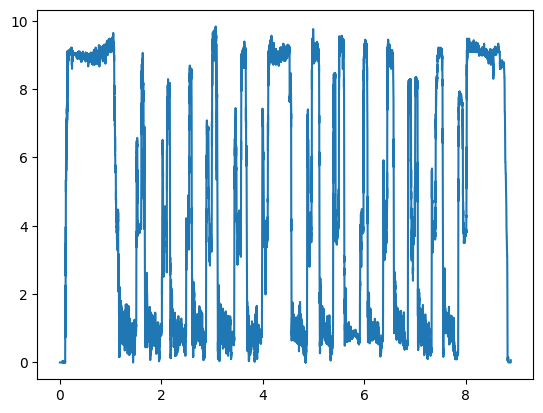

In [2]:
plot_speed_profile(speed_profile_from_data("2023-10-23"))